# Julia Workshop, Day 4: Benchmarking, Debugging, Modules

Goals for today:

- Finish understanding type stability and type groundedness
- Learn tools for measuring performance
- Use the Julia debugger
- Look at how code is loaded

Next time:

- Making our own module
    - Looking at the best workflows for writing Julia
- Adding documentation and tests
- Organizing your programs

## `@code_warntype` gotchas

- Default values and keyword arguments
- Recall `foo(x::Int=1) = ...` actually defines two methods!

```julia
foo(x) = ...
foo()  = foo(1)
```

- What if `foo` is type-stable but not type-grounded but you look at only the second method?

In [1]:
function bar(x=4.0)
    x = x / 2
    ceil(Int, x)
end

@code_warntype bar()

MethodInstance for bar()
  from bar() @ Main In[1]:1
Arguments
  #self#::Core.Const(bar)
Body::Int64
1 ─ %1 = (#self#)(4.0)::Core.Const(2)
└──      return %1



In [2]:
@code_warntype bar(4)

MethodInstance for bar(::Int64)
  from bar(x) @ Main In[1]:1
Arguments
  #self#::Core.Const(bar)
  x@_2::Int64
Locals
  x@_3::Union{Float64, Int64}
Body::Int64
1 ─      (x@_3 = x@_2)
│        (x@_3 = x@_3::Int64 / 2)
│   %3 = Main.ceil(Main.Int, x@_3::Float64)::Int64
└──      return %3



- Something similar happens with keyword arguments

In [3]:
function kwfunc(a::Int, b::Int; c::Int=0)
    d = if c == 1
        2.0
    elseif c == 2
        1.0f0
    else
        rand(rand([Int8, Int16, Int32, Int64]))
    end

    a_nonexistent_function(d)

    a + b
end

kwfunc (generic function with 1 method)

In [4]:
@code_warntype kwfunc(1, 2)

MethodInstance for kwfunc(::Int64, ::Int64)
  from kwfunc(a::Int64, b::Int64; c) @ Main In[3]:1
Arguments
  #self#::Core.Const(kwfunc)
  a::Int64
  b::Int64
Body::Int64
1 ─ %1 = Main.:(var"#kwfunc#1")(0, #self#, a, b)::Int64
└──      return %1



- A new tool to the rescue: `Cthulhu.jl` gives you the `@descend` macro, which is essentially an interactive, recusive `@code_warntype`

- Another interesting tool I'm not going to demo: `JET.jl` is an experimental static typechecker for Julia. This can help you make sure your program is both type-stable and error-free!

## Benchmarking

- When you're trying to make your code run faster, it's always a good idea to get a sense of:
  - Whether you're actually making it faster
  - Where you should focus your efforts (sometimes improving a single function can make your whole program significantly faster)
- Introducing two new tools:
  - `BenchmarkTools.jl`: tools for gathering data on performance of some code
  - `FlameGraph.jl`: tools for examining where time is spent in your code

In [5]:
using LinearAlgebra

struct Transform
    n::Int
    rotation::Matrix{Float32}
    translation::Vector{Float32}
end

function Transform(n::Int; rotation=nothing, translation=nothing)
    r = if isnothing(rotation)
        Matrix(Diagonal(ones(Float32, n)))
    else
        rotation
    end
    t = if isnothing(translation)
        zeros(Float32, n)
    else
        translation
    end
    Transform(n, r, t)
end 

function apply(T::Transform, x::Vector{Float32})
    rotated = apply_rotation(T, x)
    translated = apply_translation(T, rotated)
    translated
end

apply_rotation(T::Transform, x::Vector{Float32})    = T.rotation * x
apply_translation(T::Transform, x::Vector{Float32}) = T.translation .+ x;

In [6]:
using Random
import Random.rand

function rand(::Type{Transform}, n::Int)
    t = (rand() < 0.3) ? (randn(n)) : nothing
    r = if rand() < 0.3
        Matrix(qr(rand(n, n)).Q)
    else
        nothing
    end
    Transform(n; rotation=r, translation=t)
end

rand (generic function with 83 methods)

In [7]:
function apply_all(Ts::Vector{Transform}, x::Vector{Float32})
    for T in Ts
        x = apply(T, x)
    end
    x
end

function apply_all(Ts::Vector{Transform}, xs::Vector{Vector{Float32}})
    result = Vector{Float32}[]
    
    for x in xs
        push!(result, apply_all(Ts, x))
    end
    
    result
end

apply_all (generic function with 2 methods)

- Let's try `BenchmarkTools.jl`
- This gives you overall information on the speed of execution
    - Time taken
    - Amount of time spent doing garbage collection
    - Memory usage

In [8]:
using BenchmarkTools
@benchmark apply_all(transforms, vectors) setup=(transforms=[rand(Transform, 128) for _ in 1:32]; vectors=[rand(Float32, 128) for _ in 1:64]) seconds=60

BenchmarkTools.Trial: 7906 samples with 1 evaluation.
 Range (min … max):  2.554 ms … 10.702 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.271 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.140 ms ±  1.445 ms  ┊ GC (mean ± σ):  0.98% ± 3.87%

  █▁     ▄▁▄                   ▁▁▁▂▁▁▂▁▁▁▁▁▂▃▃▃▄▄▄▃▃▃▃▂▂▁▁   ▁
  ██▅▅▆▅████▇▇▆▇▆▆▇▇▆▆▇▆▆▇▆▆▇▇▇█████████████████████████████ █
  2.55 ms      Histogram: log(frequency) by time     6.38 ms <

 Memory estimate: 2.25 MiB, allocs estimate: 4100.

- We can see from this we do many allocations, and spend a somewhat unpredictable amount of time doing GC
- This information is especially useful as a before/after comparison

- Let's try `FlameGraphs.jl`
- You don't usually directly use the package, but a visualisation package built on top
    - We'll use `ProfileSVG.jl`

In [9]:
using ProfileSVG, Profile

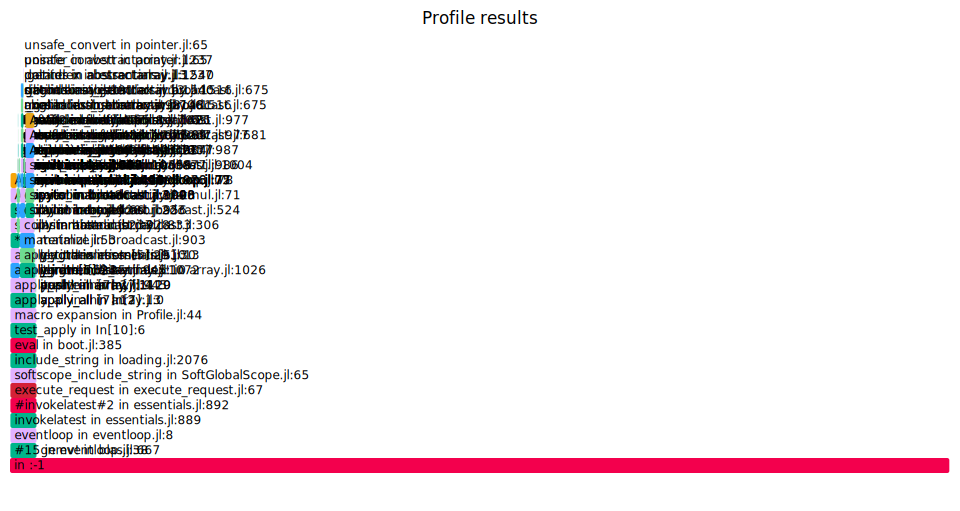

In [10]:
function test_apply(n_runs)
    for _ in 1:n_runs
        transforms=[rand(Transform, 128) for _ in 1:32]
        vectors=[rand(Float32, 128) for _ in 1:64]
        
        @profile apply_all(transforms, vectors)
    end
end

test_apply(1) # compile it!

Profile.clear()
test_apply(16384)
ProfileSVG.view() 

- From this we can see that most of the time is spent doing matrix-vector multiply
- But a decent amount of time is spent doing GC (orange)
  - If there was any dispatch happening at runtime, it gets colored red
- This gives us more concrete information about what would improve speed
  - Most importantly, we should represent rotations better (e.g. use Grassman algebra instead of matrices)
  - Adding in-place methods for applying transforms would save some time

In [11]:
# make sure out and x do not alias!
function apply!(out::Vector{Float32}, T::Transform, x::Vector{Float32})
    # apply rotation
    # out = T.rotation * x
    mul!(out, T.rotation, x)
    # apply translation
    out .+= T.translation
    out
end

function apply_all_inplace(Ts::Vector{Transform}, x::Vector{Float32})
    out = zero(x) # out is the same type as x but filled with zeros
    for T in Ts
        apply!(out, T, x)
        copyto!(x, out)
    end
    x
end

function apply_all_inplace(Ts::Vector{Transform}, xs::Vector{Vector{Float32}})
    result = Vector{Float32}[]
    
    for x in xs
        push!(result, apply_all_inplace(Ts, x))
    end
    
    result
end

apply_all_inplace (generic function with 2 methods)

In [12]:
@benchmark apply_all_inplace(transforms, vectors) setup=(transforms=[rand(Transform, 128) for _ in 1:32]; vectors=[rand(Float32, 128) for _ in 1:64]) seconds=30

BenchmarkTools.Trial: 3930 samples with 1 evaluation.
 Range (min … max):  2.482 ms … 9.903 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     4.104 ms             ┊ GC (median):    0.00%
 Time  (mean ± σ):   4.208 ms ± 1.351 ms  ┊ GC (mean ± σ):  0.01% ± 0.44%

  █                 ▁▃                  ▂                    
  █▂▂▁▁▁▁▁▁▂▂▁▁▁▁▁▁▂██▃▂▂▁▂▁▁▂▁▂▂▁▁▁▁▁▃▆█▄▂▂▁▂▁▁▁▂▁▁▁▁▂▁▁▂▃ ▂
  2.48 ms        Histogram: frequency by time       7.29 ms <

 Memory estimate: 37.91 KiB, allocs estimate: 68.

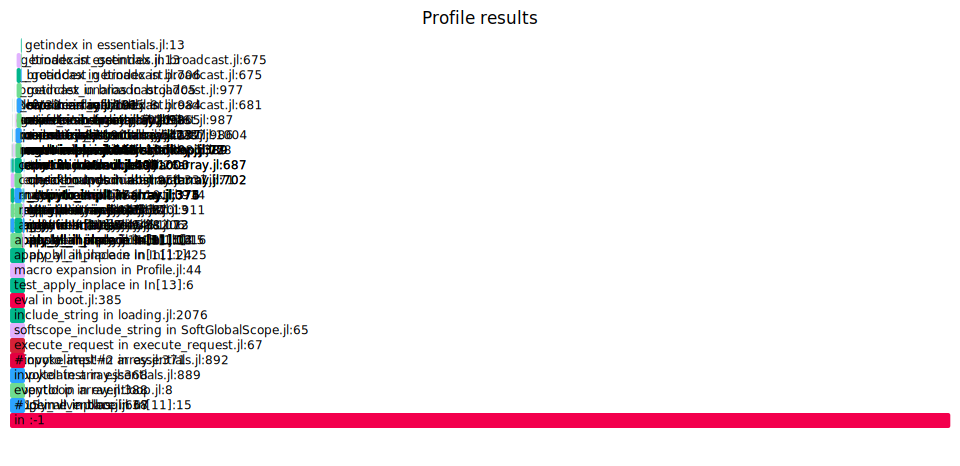

In [13]:
function test_apply_inplace(n_runs)
    for _ in 1:n_runs
        transforms=[rand(Transform, 128) for _ in 1:32]
        vectors=[rand(Float32, 128) for _ in 1:64]
        
        @profile apply_all_inplace(transforms, vectors)
    end
end

test_apply_inplace(1) # compile it!

Profile.clear()
test_apply_inplace(16384)
ProfileSVG.view() 

## The Debugger

- A debugger is a tool to run another program and strategically "pause" its execution so that program states can be examined
- If you're putting a lot of `println`s in your program to check that things are correct, consider using a debugger instead
- `Debugger.jl` is quite good, but unfortunately doesn't yet support `rr`-style "time-traveling" execution traces

In [14]:
read_data_1() = reinterpret(Float64, UInt64[0x552192cc621cf3da, 0x5ce07573af5e6c0b, 0x7fe9efe466b4b559])
read_data_2() = reinterpret(Float64, UInt64[0x556ca9faa3276b68, 0x556f6ea19897afff, 0x7fe72e0b2433a49d])

function debugme()
    data1 = read_data_1()
    data2 = read_data_2()
    
    @assert !any(isnan.(data1))
    @assert !any(isnan.(data2))
 
    (data1 + data2) - (data1 .* data2)
end

debugme()

3-element Vector{Float64}:
  -3.9483e205
  -8.624e242
 NaN

In [15]:
function inner(l)
    acc = 1
    for j in 1:l
        acc *= l + j
    end
    acc
end

function outer(k)
    i = 0
    for j in 1:k
        i += inner(k-j)
    end
    i
end

outer (generic function with 1 method)

## Code Loading and Modules

- So far, we've introduced two methods for loading code:
  - `include`
  - `using`/ `import`
- `include("file.jl")` is similar to `#include "file.h"` in the C preprocessor, it's essentially dumping the contents of `file.jl` where the `include` call is

- `using Module` is more similar to `import module` in Python, except there's no magic here
  - In e.g. Python or Java, modules are tied to the filesystem
  - In Julia, they are declared explicitly
  - `using` is also idempotent

In `file1.jl`:

```julia
module MyModule

include("file2.jl")

end # module MyModule
```

In `file2.jl`:

```julia
foo(x) = 2x
```

Note:

- `file1` and `file2` are not modules
- `MyModule` is the only module here, and it contains everything defined in `file2.jl`
  - However, `foo` will not be usable after calling `using MyModule`
  - It will after `import MyModule.foo`
  - Symbols are private by default

In `file1.jl`:

```julia
module MyModule
export MySubmodule

include("file2.jl")

end # module MyModule
```

In `file2.jl`:

```julia
module MySubmodule
export foo

foo(x) = 2x
end # module MySubmodule
```

Now:

- `MyModule` contains a _submodule_ `MySubmodule`
- We can use it like so:

```julia
include("file1.jl")

using .MyModule

MySubmodule.foo(5)

using MySubmodule
foo(6)
```

### Why Modules?

- Organize logically related code
  - Think a few types and functions which all work together to accomplish a goal
- Keep _coupling_ low
  - A module should be somewhat contained, possibly a self-contained extension to another
  - Cross-module dependencies should be kept to _interfaces_, and should avoid relying on internal details of another module
- Highly coupled code is often _brittle_ or hard to change
- Code with low coupling is frequently better-specified and more robust

In [16]:
module Foo

import Base: length

export AbstractMyData, MyData, foo

"""
    abstract type AbstractMyData{T <: Number} end

All subtypes of AbstractMyData will provide the following methods:

- `length(::AbstractMyData)`: the number of datapoints
- `process(::AbstractMyData)`: process the data
"""
abstract type AbstractMyData{T <: Number} end

struct MyData{T <: Number} <: AbstractMyData{T}
    n::Int
    xs::Vector{T}
    ys::Vector{T}
end

process(m::MyData) = (m.xs .^ 2) ./ (2 .* m.ys)
length(m::MyData)  = m.n

end # module Foo

Main.Foo

- The interface here is that subtypes of `AbstractMyData` will provide methods for `process` and `length`
- The interface is _not_ that subtypes of `AbstractMyData` will have a field `n`

Bad:

```julia
function myprocess(m::AbstractMyData{T}) where {T}
    ...
    z = zeros(T, m.n)
    ...
end
```

Good:

```julia
function myprocess(m::AbstractMyData{T}) where {T}
    ...
    z = zeros(T, length(m))
    ...
end
```

- This allows the internals of `Foo` to change:


```julia
struct MyData{T <: Number} <: AbstractMyData{T}
    xs::Vector{T}
    ys::Vector{T}
end

length(m::MyData) = length(m.xs)
```

## Environments

- These should be somewhat familiar if you've used `pipenv` or `conda` or `cargo` &c
- Idea: rather than having a global list of packages installed on your system, let a project define its own requirements
  - Upgrading packages for one project won't break another
  - Environments are more reproducible (less "it works on my machine")

- Open Julia and run `] generate DemoPackage` (in a convenient folder for projects)
  - This creates all the files for a project named `DemoPackage`
- Now exit Julia, change directory to `DemoPackage`
- Run `] activate .` in Julia
  - This activates the environment we just created above
  - You can also start Julia like `julia --project`
- Add `StaticArrays`
- Now if you `ls`, you'll notice a `Project.toml` and a `Manifest.toml`
  - `Project.toml` has a section called `[deps]` which has a list of direct dependencies of your project (what you've added with `] add`)
  - `Manifest.toml` maintains a list of all packages required (listed recursively)

- If you need specific version of a package, you must manually edit `Project.toml`
- Julia version numbers (e.g. "1.5.3") should follow [semver](https://semver.org/)
  - Incrementing the last ("patch") number should only be done for bugfixes and optimizations and should not change any interfaces
  - Incrementing the middle ("minor") number can only add features and must not change any interfaces
  - Incrementing the first ("major") number must be done for any _breaking_ changes

## Unit Tests

- Unit tests should be a collection of results you expect from your software
- This lets you make sure that your code is correct
  - Especially helpful when changing code
  - "Did I break anything?" just run your tests again!
- Before writing tests, we need some code to test!

In [17]:
module DemoPackage

import Base: +, -, *, /, one, zero, convert, promote_rule, real

export DualNumber, Polynomial, derivative, dual


"""
    DualNumber{T <: Real} <: Number

Represents a number of the form ``a + bϵ`` where ``a`` and ``b`` are real, and ``ϵ^2 = 0``.
"""
struct DualNumber{T <: Real} <: Number
    real::T
    dual::T
end

DualNumber(a::Real, b::Real) = DualNumber(promote(a, b)...)

real(a::DualNumber) = a.real
dual(a::DualNumber) = a.dual

one(::Type{DualNumber{T}}) where {T}  = DualNumber(one(T), zero(T))
zero(::Type{DualNumber{T}}) where {T} = DualNumber(zero(T), zero(T))

+(a::DualNumber, b::DualNumber) = DualNumber(real(a) + real(b), dual(a) + dual(b))
-(a::DualNumber, b::DualNumber) = DualNumber(real(a) - real(b), dual(a) - dual(b))
*(a::DualNumber, b::DualNumber) = DualNumber(real(a) * real(b), (real(a) * dual(b)) + (dual(a) * real(b)))
/(a::DualNumber, c::DualNumber) = DualNumber(real(a) / real(b), ((dual(a) * real(b)) - (real(a) * dual(b))) / (real(b)^2))

convert(::Type{DualNumber{T}}, x::Real) where {T} = DualNumber(convert(T, x), zero(T))
convert(::Type{DualNumber{T}}, x::DualNumber{U}) where {T, U} = DualNumber(convert(T, real(x)), convert(T, dual(x)))
promote_rule(::Type{DualNumber{T}}, ::Type{U}) where {T, U <: Real} = DualNumber{promote_type(T, U)}


"""
    Polynomial{T <: Real}
    
A polynomial with coefficients of type `T`. Is of the form: ``c + ∑_i x^i \\text{\\tt coeffs}[i]``

Has two fields:
- `c::T`, the constant 
- `coeffs::Vector{T}`, the coefficients for powers of `x`.

Polynomials can be evaluated by calling them:

```julia
# p(x) = 1 + 2x + 3x^2 + 4x^3
p = Polynomial(1, [2, 3, 4])
p(1) # returns 10
```
"""
struct Polynomial{T <: Real}
    c::T
    coeffs::Vector{T}
end

function (p::Polynomial{T})(x::U) where {T, U}
    acc  = zero(promote_type(T, U))
    xpow = one(U)
    for i in 1:length(p.coeffs)
        xpow *= x
        acc  += p.coeffs[i] * xpow
    end
    acc + p.c
end

"""
    derivative(::Polynomial, at)

Take the derivative of a polynomial at `at`.
"""
derivative(p::Polynomial, at::Real) = DualNumber(at, one(at)) |> p |> dual

"""
    derivative(::Polynomial)

Take the derivative of a polynomial. Returns a function which evaluates to the derivative.
"""
derivative(p::Polynomial) = (at -> derivative(p, at))

end # module DemoPackage

Main.DemoPackage

- Let's write some tests!
- Make a folder called `test` next to `src`, and add a file `runtests.jl` so your package looks like

```
DemoPackage
├─Manifest.toml
├─Project.toml
├─src
│ └─DemoPackage.jl
└─test
  └─runtests.jl
```

- We'll write our tests all in that file for now, but for larger projects you'll probably want to separate them into multiple files and `include` them
- Add:

```julia
using Test, DemoPackage

@test true
```

- We now need to make a separate environment for tests
  - `] activate test`
  - `] add Test Random`—you do need to add standard library packages to `Project.toml`
- Run the tests using:

```bash
julia --project -e "using Pkg; Pkg.test()"
```

- Now we can add some real tests!
- We can separate them into `testset`s

```julia
using Random

@testset "DualNumber" begin
    # tests for dual numbers would go here
    n1 = DualNumber(rand(), rand())
    @test (n1 * one(n1)) == n1
    @test (n1 + zero(n1)) == n1
    # ...
end

@testset "Polynomial" begin
    p1 = Polynomial(1, Int[]) # p(x) = 1
    @test p1(rand()) == 1
    @test p1(0) == 1
    
    p2 = Polynomial(0, [1]) # identity
    for _ in 1:10
        x = randn()
        @test p2(x) == x
    end
    
    p3  = Polynomial(1, [2, 3, 4])
    fp3 = x -> (1 + (2x) + (3x^2) + (4x^3))
    for _ in 1:10
        x = randn()
        @test fp3(x) ≈ p3(x)
    end
end

@testset "Differentiation" begin
    # p(x)  = 1 + x + 2x^2 + 3x^3
    p1  = Polynomial(1., [1., 2., 3.])
    # p'(x) = 1 + 4x + 9x^2
    dp1 = Polynomial(1., [4., 9.])
    
    for _ in 1:10
        x = randn()
        @test derivative(p1, x) ≈ dp1(x)
        @test derivative(p1)(x) ≈ dp1(x)
    end
end
```

- Strategies for writing tests:
  - Come up with some examples worked out by hand or a known good program
  - Don't confirm things you know to be true, you are now your own adversary!
  - Every time you fix a bug, consider adding a test to make sure it doesn't come back

## Documentation

- Docstrings are added like Python, but unlike Python support Markdown syntax
- A standard tool for documentation is `Documenter.jl`
- To use it, we'll add its own environment just like for testing (run in your project root folder)

```
] activate docs
] add Documenter
```

- Then, add a `make.jl` file in the docs folder:


```julia
push!(LOAD_PATH, "../src/")  # this makes sure your package can be loaded
using Documenter, DemoPackage

makedocs(sitename="Dual Number Polynomial Differentiation", remotes=nothing)
```

- Finally, add an `index.md` file (should be at `DemoPackage/docs/src`):

- Now, in the `docs` directory, you can build the docs like `julia --project make.jl`
- A good way to run a test serve of them is `python3 -m http.server 8000 --directory build`, which you can then access at `http://localhost:8000`

## Using `git`

- I don't want to spend time on using git, but it's a fanastic tool
- A good guide is available [here](https://git-scm.com/book/en/v2)
- _You should use it_
  - Don't ever comment out an old version of code, just branch and delete it!
- A starting `.gitignore` for Julia projects is:

```
.DS_Store
/docs/build/
/docs/site/
.vscode
*.jl.cov
*.jl.*.cov
/Manifest.toml
/test/Manifest.toml
/docs/Manifest.toml
```

## Organizing a Program

- It's difficult to give concrete instructions

Things to keep in mind:

- Code is read more often than it is written
  - Give things meaningful names
  - Write a comment if you had to think about what to do
  - Follow the style guide
  - No "magic numbers"
- Humans have atrocious working memory
  - Pieces of your program (modules, types, functions) should have a clear, understandable meaning
  - You should be able to reason abstractly about them

1. Start with your data.
  - Ask:
    - What does it look like? What's a good representation?
    - The best representation may not be the way you get data
    - Tabular/relational? Time series? Graphical? Tree? Geographical?
    - Which pieces of data always go together?
  - Write types to store your data
    - Types are cheap!
    - If you need strong guarantees, write inner constructors
    - Write some outer constructors for ways you'll be commonly constructing these types
    - Don't be afraid to write your own array type or implement an algebra

2. Write some helper functions to get at common information you'll need
  - Functions are cheap!
  - Examples:
    - If you're storing start and end times, write a `duration` function
    - If you're storing polar coordinates, write a function to get Cartesian coordinates
    - If you have a graph, write functions to make it easier to move around/get edge information
  - Make the names descriptive: this helps make your code readable
    - Consider `timer.t_end - timer.t_start` vs `duration(timer)`
    - Or `coord.r * cos(coord.θ)` vs `x(coord)`

3. Sketch the main bit of your program
  - The `main` function or your algorithm
  - Keep it very high level
  - Call functions you wish existed
  - Give things meaningful names, autocomplete exists for a reason!

4. Fill in functions you named in 3.
  - Also keep them high level, this step is recursive
  - Remember, functions should have a clear semantic meaning
  - If you use a similar bit of code in more than ~three places, consider separating it into a function
  
Clues you may need to write another function:

- Lots of nested `if`s and `for`s
- Very long functions which do many things

## Miscellanea

- There is so much more to Julia

### Some Useful Packages

- For plotting:
  - `Plots.jl` is very flexible, and can output to many backends
    - It's somewhat slow, especially to get started
    - However, it can output to `pgfplots` so your plots can match your TeX documents
    - The documentation isn't very good
  - `Makie.jl` is a newer project with a focus on performance
    - Can render on GPUs, including ray tracing on AMD GPUs
    - Also can make interactive plots
- For dataframes (like `pandas`), consider `DataFrames.jl`
- `Zygote.jl` does automatic differentiation on whole programs
  - `RayTracer.jl` was a pure-Julia differentiable ray tracer for e.g. inverse graphics 
- `Unitful.jl` does arithmetic and conversions on quantities with units with minimal runtime cost
- `Measurements.jl` does uncertainty propagation
- `FFTW.jl` for FFTs, `DifferentialEquations.jl`, `JuMP.jl` & `ModelingToolkit.jl`, `Yao.jl` for QC, &c

Beyond this, [juliapackages.com](https://juliapackages.com/packages) has a categorized list of packages, and the number of stars on GitHub/GitLab

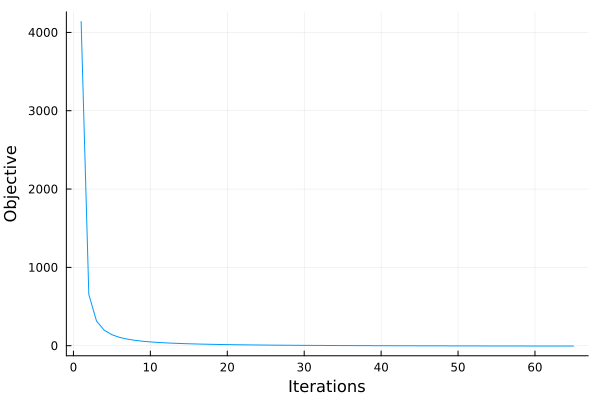

In [18]:
using Zygote, Plots

c = 10 .* randn(8)
objective(x) = sum((@. 3x^2 + 2x + c))
# objective(x) = sum( (3 .* x .^ 2) .+ (2 .* x) .+ c )

function gradient_descent(f, iterations::Integer, step_size, x0)
    iterate = copy(x0)
    history = zeros(iterations + one(iterations))
    
    for i in 1:iterations
        history[i] = f(iterate)
        
        gradient = f'(iterate)
        iterate .-= (step_size / i) .* gradient
    end
    
    history[end] = f(iterate)
    iterate, history
end

_, history = gradient_descent(objective, 64, 0.1, 20 .* rand(8))
plot(history, ylabel="Objective", xlabel="Iterations", legend=nothing)

### Functional-style programming

- Julia has first-class functions
  - `myfunc = sin; myfunc(1.0)`

This allows "higher-order" functions:

- `sort(collection; lt=... by=...)`
  - Allows specifying the comparison `<`
  - Also allows a map using `by`
  - `sort(::Vector{ComplexF32}, by=abs)`
  - `sort(::Vector{String}, by=(s -> s[1]))`

In [19]:
apply(f, x...) = f(x...)
apply(sin, π/2)

1.0

- `map(f, collection)` calls `f` on every element of `collection`
  - `foreach(f, collection)` does the same, but discards the result

- `reduce(op, collection)` applies `op` to the whole collection
  - For example, `reduce(+, collection)` is the sum
  - `reduce(*, collection)` is the product
  - `reduce(min, collection)` finds the smallest element
  - `foldl` and `foldr` guarantee direction

- `filter(pred, collection)` keeps only the elements of `collection` which satisfy `pred`
  - `filter((x -> x > zero(x)), collection)` keeps positive values
  - `filter(!isone, collection)` keeps all elements which are not the multiplicative identity

- Why should you care?
  - Some problems can be expressed much more naturally

In [20]:
import Base: map, reduce, filter

struct Tree{T}
    val::T
    children::Vector{Tree{T}}
end

Tree(val::T) where {T} = Tree(val, Tree{T}[])

val(t::Tree)      = t.val
children(t::Tree) = t.children

isleaf(t::Tree) = isempty(children(t))

isleaf (generic function with 1 method)

In [21]:
_map(f) = (st -> map(f, st))
# apply f to every node in the tree
map(f, t::Tree{T}) where {T} =
    if isleaf(t)
        Tree(f(val(t)))
    else
        mapped_children = map(_map(f), children(t))
        Tree(f(val(t)), mapped_children)
    end

map (generic function with 77 methods)

In [22]:
_reduce(f, init) = (st -> reduce(f, st, init))
# accumulate f from the bottom of the tree to the top
reduce(f, t::Tree, init) =
    if isleaf(t)
        f(val(t), init)
    else
        inner = map(_reduce(f, init), children(t))
        f(val(t), reduce(f, inner, init=init))
    end

reduce (generic function with 7 methods)

In [23]:
# keep only subtrees whose root satisfies f, and return nothing otherwise
filter(f, t::Tree{T}) where {T} =
    if f(val(t))
        inner = Tree{T}[]
        keepnotnothing = st -> let filtered = filter(f, st)
            if !isnothing(filtered)
                push!(inner, filtered)
            end
        end
        foreach(keepnotnothing, children(t))
        Tree(val(t), inner)
    else
        nothing
    end

filter (generic function with 14 methods)

In [24]:
t = Tree(1, [
        Tree(2, [
            Tree(3),
            Tree(4),
            Tree(5)
        ]),
        Tree(6)
    ])

Tree{Int64}(1, Tree{Int64}[Tree{Int64}(2, Tree{Int64}[Tree{Int64}(3, Tree{Int64}[]), Tree{Int64}(4, Tree{Int64}[]), Tree{Int64}(5, Tree{Int64}[])]), Tree{Int64}(6, Tree{Int64}[])])

In [25]:
prettyprint(depth::Int) = (t::Tree -> prettyprint(t, depth + 1))

function prettyprint(t::Tree, depth::Int=0)
    println("  "^depth, val(t))
    foreach(prettyprint(depth + 1), children(t))
end
    
prettyprint(t)

1
    2
        3
        4
        5
    6


In [26]:
reduce(+, t, 0)

21

In [27]:
map(x -> x/2, t) |> prettyprint

0.5
    1.0
        1.5
        2.0
        2.5
    3.0


In [28]:
filter(x -> x < 5, t) |> prettyprint

1
    2
        3
        4


### Metaprogramming

- Code is just a kind of data!

In [29]:
code_chunk = quote
    A = rand(5)
    A .+= randn(5)
    sum(A)
end

quote
    #= In[29]:2 =#
    A = rand(5)
    #= In[29]:3 =#
    A .+= randn(5)
    #= In[29]:4 =#
    sum(A)
end

In [30]:
typeof(code_chunk)

Expr

In [31]:
dump(code_chunk)

Expr
  head: Symbol block
  args: Array{Any}((6,))
    1: LineNumberNode
      line: Int64 2
      file: Symbol In[29]
    2: Expr
      head: Symbol =
      args: Array{Any}((2,))
        1: Symbol A
        2: Expr
          head: Symbol call
          args: Array{Any}((2,))
            1: Symbol rand
            2: Int64 5
    3: LineNumberNode
      line: Int64 3
      file: Symbol In[29]
    4: Expr
      head: Symbol .+=
      args: Array{Any}((2,))
        1: Symbol A
        2: Expr
          head: Symbol call
          args: Array{Any}((2,))
            1: Symbol randn
            2: Int64 5
    5: LineNumberNode
      line: Int64 4
      file: Symbol In[29]
    6: Expr
      head: Symbol call
      args: Array{Any}((2,))
        1: Symbol sum
        2: Symbol A


In [32]:
Meta.show_sexpr(code_chunk)

(:block,
  :(#= In[29]:2 =#),
  (:(=), :A, (:call, :rand, 5)),
  :(#= In[29]:3 =#),
  (:.+=, :A, (:call, :randn, 5)),
  :(#= In[29]:4 =#),
  (:call, :sum, :A)
)

In [33]:
Meta.show_sexpr(Meta.parse("1 + 1"))

(:call, :+, 1, 1)

In [34]:
macro runtwice(call)
    quote
        $call
        $call
    end
end

println("Here")
@runtwice println("Hello, world")
println("After")

Here
Hello, world
Hello, world
After


In [35]:
const DEBUG = true

macro myassert(expression::Expr)
    str = string(expression)
    if DEBUG
        quote
            if $expression
                nothing
            else
                throw(AssertionError(str))
            end
        end
    else
        quote end
    end
end

@myassert 1 == 1
macroexpand(Main, quote @myassert sqrt(2) == 1.4 end)

quote
    #= In[35]:19 =#
    begin
        #= In[35]:7 =#
        if Main.sqrt(2) == 1.4
            #= In[35]:8 =#
            Main.nothing
        else
            #= In[35]:10 =#
            Main.throw(Main.AssertionError(Main.str))
        end
    end
end